In [143]:
import numpy as np
import matplotlib.pyplot as plt
import xrd
from importlib import reload
reload(xrd)

# from experiment file
# params = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]
# default
# params = [0.01305, 0.0017, 5800e-8, 3500e-8, 0.004845, 4000e-8, -500e-8]
# idk
# params = [0.0125, 0.0075, 5e-05, 4.99e-05, 0.005, 5e-06, -6.01e-05]

params = [0.026807, 0.018359, 4.084e-05, 1.295e-05, 0.009903, 2.870e-05, -5.607e-06]
        
original_curve, original_profile = xrd.compute_curve_and_profile(
    array=params,
    dl=100e-8
)

In [144]:
import torch
import xrd
import helpers as h
import model_common
from importlib import reload

# Reload modules to get latest changes
reload(xrd)
reload(model_common)
reload(h)

MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3.pt'

device = "mps"

checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"✅ Loaded checkpoint from {MODEL_CHECKPOINT}")
print(f"Checkpoint contains: {list(checkpoint.keys())}")

# Initialize model
model = model_common.XRDRegressor().to(device)
model.load_state_dict(checkpoint['model'])

# Prepare data for model - ВИПРАВЛЕНО!
m1_ML = len(original_curve.ML_Y)
parsed_X = torch.tensor(np.linspace(0, m1_ML - 1, m1_ML), dtype=torch.float32).unsqueeze(0)  # Dummy X
parsed_Y = torch.tensor(original_curve.ML_Y, dtype=torch.float32).unsqueeze(0)

ds = model_common.NormalizedXRDDataset(parsed_X, parsed_Y, train=False)
dl = torch.utils.data.DataLoader(ds, batch_size=1)

preds = []
with torch.no_grad():
    for y, _ in dl:
        p = model(y.to(device))
        preds.append(p.to(device))

P = torch.cat(preds, dim=0)
Theta_hat = model_common.denorm_params(P)
predicted_params = Theta_hat[0].cpu().numpy()
print("Original params: ", params)
print("Predicted params:", predicted_params)

✅ Loaded checkpoint from checkpoints/dataset_10000_dl100_7d_v3.pt
Checkpoint contains: ['model', 'L', 'epoch', 'val_loss']
Original params:  [0.026807, 0.018359, 4.084e-05, 1.295e-05, 0.009903, 2.87e-05, -5.607e-06]
Predicted params: [ 1.9852877e-02  1.2646489e-02  4.6368201e-05  2.0020891e-05
  1.5686428e-02  3.0941577e-05 -2.8323360e-05]


In [145]:
Theta_hat

tensor([[ 1.9853e-02,  1.2646e-02,  4.6368e-05,  2.0021e-05,  1.5686e-02,
          3.0942e-05, -2.8323e-05]], device='mps:0')

Predicted parameters: [ 1.9852877e-02  1.2646489e-02  4.6368201e-05  2.0020891e-05
  1.5686428e-02  3.0941577e-05 -2.8323360e-05]


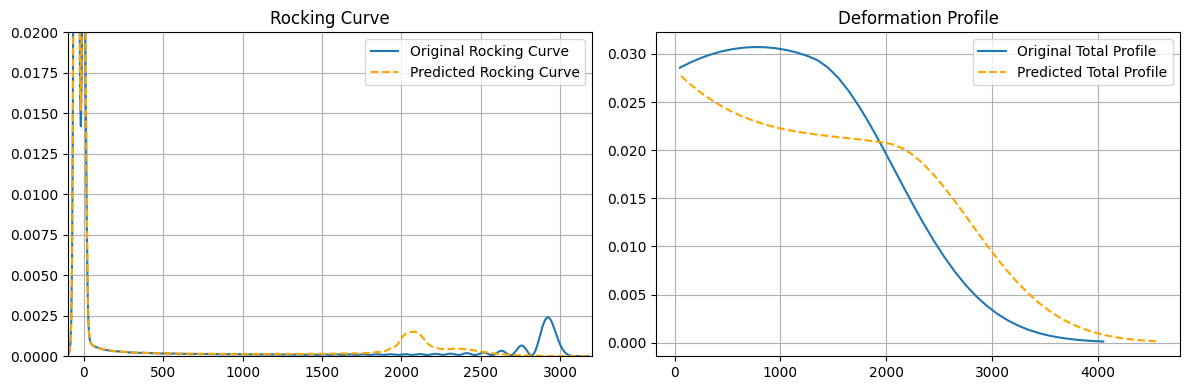

In [146]:
import matplotlib.pyplot as plt
import xrd
from importlib import reload
reload(xrd)

predicted_params = Theta_hat[0].cpu().numpy()
print("Predicted parameters:", predicted_params)
        
predicted_curve, predicted_profile = xrd.compute_curve_and_profile(
    array=predicted_params,
    dl=100e-8
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 12 width, 4 height

# Rocking Curve: plot original (solid) and predicted (orange, dashed)
axes[0].set_title("Rocking Curve")
axes[0].plot(original_curve.X_DeltaTeta, original_curve.Y_R_vseZ, label="Original Rocking Curve", color='C0', linestyle='-')
axes[0].plot(predicted_curve.X_DeltaTeta, predicted_curve.Y_R_vseZ, label="Predicted Rocking Curve", color='orange', linestyle='--')
axes[0].set_ylim(0, 0.02)
axes[0].set_xlim(-100, 3200)
axes[0].grid(True)
axes[0].legend()

# Deformation Profile: plot original (solid) and predicted (orange, dashed)
axes[1].set_title("Deformation Profile")
axes[1].plot(original_profile.X, original_profile.total_Y, label="Original Total Profile", color='C0', linestyle='-')
axes[1].plot(predicted_profile.X, predicted_profile.total_Y, label="Predicted Total Profile", color='orange', linestyle='--')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()
